In [496]:
train_path = "./new_train/new_train"
test_path = "./new_val_in/new_val_in"
submission_path = "./sample_submission.csv"
submission_dir = "./submissions"

In [422]:
# Train Val Split
TRAIN_SIZE = 0.9
VAL_SIZE = 0.1

# training config
NUM_EPOCH = 10
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
EARLY_STOP_MAX = 6

# feature engineering configs
NEARBY_DISTANCE_THRESHOLD = 50.0  # Distance threshold to call a track as neighbor
DEFAULT_MIN_DIST_FRONT_AND_BACK = 100. # default distance 

In [423]:
import os
import copy
import pickle
import numpy as np
from glob import glob
import pandas as pd
from tqdm import tqdm
from typing import Tuple
import matplotlib.pyplot as plt


import optuna
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Data 

In [511]:
class ArgoverseDataset(Dataset):
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
        
        if self.transform:
            data = self.transform(data)

        return data

In [512]:
train = ArgoverseDataset(data_path=train_path)
test = ArgoverseDataset(data_path=test_path)

In [513]:
train_size = int(TRAIN_SIZE * len(train))
val_size = len(train) - train_size
train, val = torch.utils.data.random_split(train, [train_size, val_size])

## Preprocessing

In [427]:
# generate social features
def get_social_features(scene):
    """
    Extract social features:
        1. number of neighbors
        2. min front/back distance at each timestamp
    """
    agent_idx = np.where(scene["agent_id"] == np.unique(scene["track_id"].flatten()))[0][0]
    social_masks = scene["car_mask"].flatten()
    
    # remove agent track from social tracks
    social_masks[agent_idx] = 0
    
    # get agent_traj and social_trajs
    agent_traj = scene['p_in'][agent_idx]
    social_trajs = scene['p_in'][social_masks.astype(bool)]
    
    # compute social features
    num_neighbors = count_num_neighbors(agent_traj, social_trajs)
#     min_dist = get_min_distance_front_and_back(agent_traj, social_trajs)
#     return np.concatenate((num_neighbors, min_dist), axis=1)
    return num_neighbors

In [428]:
def count_num_neighbors(agent_traj, social_trajs):
    """
    Calculate euclidean distance between agent_traj and social_trajs
    if distance is less than NEARBY_DISTANCE_THRESHOLD, then num_neighbors++
    
    Args:
        agent_traj (np.array): data for agent trajectory
        social_trajs (np.array): array of other agents' trajectories
    Returns:
        (np.array): 
    """
    num_neighbors = []
    dist = np.sqrt(
        (social_trajs[:, :, 0] - agent_traj[:, 0])**2 
        + (social_trajs[:, :, 1] - agent_traj[:, 1])**2
    ).T
    num_neighbors = np.sum(dist < NEARBY_DISTANCE_THRESHOLD, axis=1)
    return num_neighbors.reshape(-1, 1)

In [429]:
def get_min_distance_front_and_back(agent_traj, social_trajs):
    """Use minimum distance to the vehicle in front, to the vehicle in back"""
    traj_len = agent_traj.shape[0]
    min_distance_front_and_back = np.full(traj_len, DEFAULT_MIN_DIST_FRONT_AND_BACK)
    
    for i in range(traj_len):
        # Agent coordinates
        agent_x, agent_y = agent_traj[i, 0], agent_traj[i, 1]

#         # Compute distances for all the social tracks
#         for social_traj in social_trajs[:, i, :]:
#             neigh_x, neigh_y = social_traj[0], social_traj[1]

#             # Distance between agent and social
#             instant_distance = np.sqrt((agent_x - neigh_x)**2 + (agent_y - neigh_y)**2)

#             # If not a neighbor, continue
#             if instant_distance > NEARBY_DISTANCE_THRESHOLD:
#                 continue
                
        agent = agent_traj[i]
        social = social_trajs[:, i, :]

        instant_distance = min(np.sqrt(np.sum((agent - social)**2, axis=1)))
        if instant_distance > NEARBY_DISTANCE_THRESHOLD:
            continue
        else:
            min_distance_front_and_back[i] = instant_distance
            # Check if the social track is in front or back
#             is_front_or_back = get_is_front_or_back(
#                 agent_traj[:2, :] if i == 0 else agent_track[:i + 1, :],
#                 social_traj
#             )
            
#             if is_front_or_back == "front":
#                 min_distance_front_and_back[i, 0] = min(
#                     min_distance_front_and_back[i, 0], instant_distance)

#             elif is_front_or_back == "back":
#                 min_distance_front_and_back[i, 1] = min(
#                     min_distance_front_and_back[i, 1], instant_distance)
    return min_distance_front_and_back.reshape(-1, 1)

In [430]:
def get_is_front_or_back(agent_traj, social_p):
    pass

In [431]:
agent_traj = train_0["p_in"][1]
social_trajs = train_0["p_in"][2:5]

In [432]:
social_trajs.shape

(3, 19, 2)

In [514]:
def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp, out = [], []
    for scene in batch:
        agent_idx = np.where(scene["agent_id"] == np.unique(scene["track_id"].flatten()))[0][0]
        social_features = get_social_features(scene)
        inp.append(np.hstack([scene['p_in'][agent_idx], scene['v_in'][agent_idx], social_features]))
        out.append(scene['p_out'][agent_idx])

    inp = torch.FloatTensor(inp)
    out = torch.FloatTensor(out)
    return [inp, out]

def my_test_collect(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp, out = [], []
    for scene in batch:
        agent_idx = np.where(scene["agent_id"] == np.unique(scene["track_id"].flatten()))[0][0]
        social_features = get_social_features(scene)
        inp.append(np.hstack([scene['p_in'][agent_idx], scene['v_in'][agent_idx], social_features]))
        out.append([])

    inp = torch.FloatTensor(inp)
    out = torch.FloatTensor(out)
    return [inp, out]


train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle = False, collate_fn=my_collate, num_workers=0)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle = False, collate_fn=my_collate, num_workers=0)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle = False, collate_fn=my_test_collect, num_workers=0)
exmaple = iter(train_loader)
exmaple.next()[0][0]

tensor([[ 1.4858e+02,  2.6593e+03,  9.7674e-01,  1.4160e+01,  4.0000e+00],
        [ 1.4835e+02,  2.6601e+03, -2.2618e+00,  7.8510e+00,  4.0000e+00],
        [ 1.4840e+02,  2.6615e+03,  4.8918e-01,  1.3997e+01,  4.0000e+00],
        [ 1.4835e+02,  2.6627e+03, -5.2795e-01,  1.1960e+01,  4.0000e+00],
        [ 1.4836e+02,  2.6636e+03,  1.4605e-01,  9.1254e+00,  4.0000e+00],
        [ 1.4843e+02,  2.6645e+03,  6.3606e-01,  9.2585e+00,  4.0000e+00],
        [ 1.4844e+02,  2.6658e+03,  1.1599e-01,  1.3361e+01,  4.0000e+00],
        [ 1.4831e+02,  2.6670e+03, -1.2448e+00,  1.1686e+01,  4.0000e+00],
        [ 1.4830e+02,  2.6683e+03, -1.2394e-01,  1.2613e+01,  5.0000e+00],
        [ 1.4844e+02,  2.6695e+03,  1.3973e+00,  1.2108e+01,  5.0000e+00],
        [ 1.4833e+02,  2.6706e+03, -1.0835e+00,  1.1160e+01,  5.0000e+00],
        [ 1.4817e+02,  2.6711e+03, -1.5964e+00,  5.3164e+00,  5.0000e+00],
        [ 1.4830e+02,  2.6727e+03,  1.2815e+00,  1.5362e+01,  5.0000e+00],
        [ 1.4836e+02,  2.

In [434]:
submission = pd.read_csv(submission_path)
submission

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
0,10002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,9897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3196,99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3197,9905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3198,9910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Viz

# Data preprocessing

In [339]:
def get_relative_position(inp, out=None):
    """calculate position difference"""
    input_length = inp.shape[1]
    p_in_0 = copy.deepcopy(inp[:, 0, :2])
    
    
    if out is not None:
        out = copy.deepcopy(out)
        output_length = out.shape[1]
        for i in range(output_length - 1, 0, -1):
            out[:, i, :2] = out[:, i, :2] - out[:, i - 1, :2]
        out[:, 0, :2] = out[:, 0, :2] - inp[:, -1, :2]
        
    for i in range(input_length - 1, 0, -1):
        inp[:, i, :2] = inp[:, i, :2] - inp[:, i - 1, :2]
    inp[:, 0, :] = 0
    
    if out is not None:
        return inp, out, p_in_0
    
    return inp, p_in_0

In [340]:
def get_absolute_position(inp, out, p_in_0, return_pred_only=False):
    """position inverse difference"""
    inp[:, 0, :2] = p_in_0
    for i in range(1, inp.shape[1]):
        inp[:, i, :2] = inp[:, i, :2] + inp[:, i - 1, :2]

    out[:, 0, :2] = out[:, 0, :2] + inp[:, -1, :2]
    for i in range(1, out.shape[1]):
        out[:, i, :2] = out[:, i, :2] + out[:, i - 1, :2]
    
    if return_pred_only:
        return out
    
    return inp, out

# Training

In [435]:
# model training
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='cuda')

In [436]:
class RMSELoss(torch.nn.Module):
    """RMSE Loss"""
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, yhat, y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(yhat, y))
        return loss

## Seq2Seq (LSTM)

In [437]:
# training config
ROLLOUT_LEN = 30

# model config
INPUT_SIZE = 5
EMBEDDING_SIZE = 8
HIDDEN_SIZE = 16
OUTPUT_SIZE = 2

In [438]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, embedding_size=EMBEDDING_SIZE, hidden_size=HIDDEN_SIZE):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.linear = nn.Linear(input_size, embedding_size)
        self.lstm = nn.LSTMCell(embedding_size, hidden_size)

    def init_hidden(self, batch_size, hidden_size):
        # Initialize encoder hidden state
        h_0 = torch.zeros(batch_size, hidden_size).to(device)
        c_0 = torch.zeros(batch_size, hidden_size).to(device)
        nn.init.xavier_normal_(h_0)
        nn.init.xavier_normal_(c_0)
        return (h_0, c_0)
    
    def forward(self, X):
        init_hidden = self.init_hidden(X.shape[0], self.hidden_size)
        
        embedded = F.relu(self.linear(X))
        hidden_state = self.lstm(embedded, init_hidden)
        return hidden_state

In [439]:
class DecoderLSTM(nn.Module):
    def __init__(self, embedding_size=EMBEDDING_SIZE, hidden_size=HIDDEN_SIZE, output_size=OUTPUT_SIZE):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        
        self.linear1 = nn.Linear(output_size, embedding_size)
        self.lstm1 = nn.LSTMCell(embedding_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, X, encoder_hidden):        
        embedded = F.relu(self.linear1(X))
        hidden = self.lstm1(embedded, encoder_hidden)
        output = self.linear2(hidden[0])
        return output, hidden

In [440]:
def check_validation(val_loader, encoder, decoder, normalize=False):
    loss_fn = RMSELoss()
    
    for i_batch, batch_data in enumerate(val_loader):
        inp, out = batch_data
        inp = inp.to(device)
        out = out.to(device)
        
        # eval mode
        encoder.eval()
        decoder.eval()
        
        # Encoder
        batch_size = inp.shape[0]
        input_length = inp.shape[1]
        output_length = out.shape[1]
        input_shape = inp.shape[2]

        # Initialize losses
        loss = 0

        # Get relative position
        inp, processed_out, p_in_0 = get_relative_position(inp, out)

        # Encode observed trajectory
        for i in range(input_length):
            encoder_input = inp[:, i, :]
            encoder_hidden = encoder(encoder_input)

        # Initialize decoder input with last coordinate in encoder
        decoder_hidden = encoder_hidden
        decoder_input = encoder_input[:, :2]

        # Decode hidden state in future trajectory
        prev_p = p_in_0
        for i in range(output_length):
            decoder_output, decoder_hidden = decoder(decoder_input, encoder_hidden)

            # Update loss
            pred_out = decoder_output[:, :2] + prev_p
            loss += loss_fn(pred_out, out[:, i, :2])
            prev_p = pred_out

            # Use own predictions as inputs at next step
            decoder_input = decoder_output

        loss = loss / output_length
    return loss

In [444]:
# model training
encoder = EncoderLSTM(5)
decoder = DecoderLSTM()
encoder.to(device)
decoder.to(device)

loss_fn = RMSELoss()
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=LEARNING_RATE)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=LEARNING_RATE)

In [445]:
# training
train_losses = []
val_losses = []
prev_loss, non_decreasing_loss_cnt = -float("inf"), 0
for epoch in range(NUM_EPOCH):
    for i_batch, batch_data in enumerate(train_loader):
        inp, out = batch_data
        inp = inp.to(device)
        out = out.to(device)
        
        # Set to train mode
        encoder.train()
        decoder.train()

        # Initialize losses
        loss = 0

        # Encoder
        batch_size = inp.shape[0]
        input_length = inp.shape[1]  # expected: 19
        output_length = out.shape[1]  # expected: 30
        input_shape = inp.shape[2]
        total_length = input_length + output_length  # expected: 49

        # Get relative position  
        initial_p_in = inp[:, 0, :2].detach().clone()
        inp[:, :, :2] = inp[:, :, :2] - initial_p_in[:, None]
        
#         inp, processed_out, p_in_0 = get_relative_position(inp, out)
#         inp_cols = [0, 1, 4]
        # Encode observed trajectory
        for i in range(input_length):
            encoder_input = inp[:, i, :]
            encoder_hidden = encoder(encoder_input)
    
        # Initialize decoder input with last coordinate in encoder
        decoder_hidden = encoder_hidden
        decoder_input = encoder_input[:, :2]

        # Decode hidden state in future trajectory
#         prev_p = p_in_0
        for i in range(output_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

            # Update loss
            loss += loss_fn(decoder_output[:, :2], out[:, i, :2] - initial_p_in)
            
#             pred_out = decoder_output[:, :2] + prev_p
#             loss += loss_fn(decoder_output[:, :2], processed_out[:, i, :2])
#             prev_p = pred_out

            # Use own predictions as inputs at next step
            decoder_input = decoder_output

        # Get average loss for pred_len
        loss = loss / output_length

        # Backpropagate
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
            
        if i_batch % 400 == 0:
            # print training loss
            training_loss = loss.item()
            train_losses.append(training_loss)
        
            # validate 
#             with torch.no_grad():
#                 val_loss = check_validation(val_loader, encoder, decoder, normalize=False)
#                 val_losses.append(val_loss.item())  
            
            print(f"Epoch {epoch+1}/{NUM_EPOCH}, batch {i_batch}/{len(train_loader)}, "\
                    + f"Training loss: {training_loss:.4f}")#\
                    #  + f", Val loss: {val_loss.item():.4f}")
            
            # early stop
#             if val_loss.item() > prev_loss:
#                 non_decreasing_loss_cnt += 1
#             else:
#                 non_decreasing_loss_cnt = 0
#                 prev_loss = val_loss.item()
            
#             if non_decreasing_loss_cnt >= EARLY_STOP_MAX:
#                 break 
                
#     if non_decreasing_loss_cnt >= EARLY_STOP_MAX:
#         break 

Epoch 1/10, batch 0/2897, Training loss: 25.9903
Epoch 1/10, batch 400/2897, Training loss: 18.4308
Epoch 1/10, batch 800/2897, Training loss: 12.7864
Epoch 1/10, batch 1200/2897, Training loss: 13.8592
Epoch 1/10, batch 1600/2897, Training loss: 11.2178
Epoch 1/10, batch 2000/2897, Training loss: 12.2561
Epoch 1/10, batch 2400/2897, Training loss: 9.6018
Epoch 1/10, batch 2800/2897, Training loss: 8.3486
Epoch 2/10, batch 0/2897, Training loss: 11.8505
Epoch 2/10, batch 400/2897, Training loss: 9.0558
Epoch 2/10, batch 800/2897, Training loss: 6.4345
Epoch 2/10, batch 1200/2897, Training loss: 8.0577
Epoch 2/10, batch 1600/2897, Training loss: 5.5263
Epoch 2/10, batch 2000/2897, Training loss: 7.1530
Epoch 2/10, batch 2400/2897, Training loss: 5.1133
Epoch 2/10, batch 2800/2897, Training loss: 4.1518
Epoch 3/10, batch 0/2897, Training loss: 7.6639
Epoch 3/10, batch 400/2897, Training loss: 5.3218
Epoch 3/10, batch 800/2897, Training loss: 4.4960
Epoch 3/10, batch 1200/2897, Training l

In [ ]:
import matplotlib.pyplot as plt
import random

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1, batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])

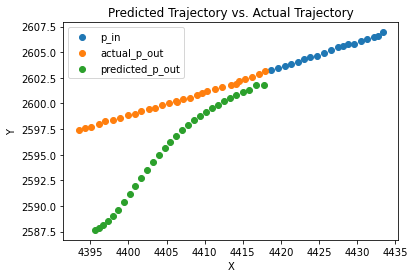

In [580]:
# fig, axs = plt.subplots(1, 1, figsize=(15, 3), facecolor='w', edgecolor='k')
agent_id = 44

plt.scatter(real_inp[agent_id].cpu().numpy()[:, 0], real_inp[agent_id].cpu().numpy()[:, 1], label="p_in")
plt.scatter(out[agent_id].cpu().numpy()[:, 0], out[agent_id].cpu().numpy()[:, 1], label="actual_p_out")
plt.scatter(decoder_outputs[agent_id].cpu().numpy()[:, 0], decoder_outputs[agent_id].cpu().numpy()[:, 1], label="predicted_p_out")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Predicted Trajectory vs. Actual Trajectory")
plt.legend()
plt.show()

In [517]:
# predict
pred_p_out = []
all_zeros_ix = []
real_inp = None
with torch.no_grad():
    for i_batch, batch_data in enumerate(train_loader):
        inp, out = batch_data
        inp = inp.to(device)
                    
        # Set to eval mode
        encoder.eval()
        decoder.eval()

        # Encoder
        batch_size = inp.shape[0]
        input_length = inp.shape[1]
        input_shape = inp.shape[2]

        # Get relative position
        initial_p_in = inp[:, 0, :2].detach().clone()
        real_inp = inp.detach().clone()
        inp[:, :, :2] = inp[:, :, :2] - initial_p_in[:, None]
#         inp, p_in_0 = get_relative_position(inp)
        
        # Encode observed trajectory
        for i in range(input_length):
            encoder_input = inp[:, i, :]
            encoder_hidden = encoder(encoder_input)

        # Initialize decoder input with last coordinate in encoder
        decoder_hidden = encoder_hidden
        decoder_input = encoder_input[:, :2]
        decoder_outputs = torch.zeros((len(inp), 30, 2))

        # Decode hidden state in future trajectory
        for i in range(30):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            decoder_outputs[:, i, :] = decoder_output + initial_p_in

            # Use own predictions as inputs at next step
            decoder_input = decoder_output
            
        # predicted_p_out
#         out = get_absolute_position(inp, decoder_outputs.to(device), p_in_0, return_pred_only=True)
        pred_p_out.append(decoder_outputs)
        break

In [465]:
predicted_p_out = torch.FloatTensor(len(val_loader), 30, 2)#.to(device)
torch.cat(pred_p_out, out=predicted_p_out)

tensor([[[1715.4297,  337.4276],
         [1715.7571,  338.4755],
         [1717.0173,  339.1839],
         ...,
         [1739.0333,  359.7098],
         [1740.0820,  360.7204],
         [1741.1708,  361.7773]],

        [[ 724.4598, 1230.1902],
         [ 724.4282, 1229.7971],
         [ 724.4906, 1229.3918],
         ...,
         [ 722.8076, 1220.7710],
         [ 722.7488, 1220.3905],
         [ 722.6932, 1220.0105]],

        [[ 574.0156, 1244.2719],
         [ 574.3720, 1244.1730],
         [ 574.5878, 1243.8409],
         ...,
         [ 581.5117, 1238.9880],
         [ 581.8642, 1238.8501],
         [ 582.2226, 1238.7168]],

        ...,

        [[1754.9185,  444.3149],
         [1754.7728,  444.2262],
         [1754.5679,  444.4013],
         ...,
         [1747.7212,  451.6100],
         [1747.5109,  451.8706],
         [1747.3057,  452.1302]],

        [[ 574.0685, 1288.6942],
         [ 573.9257, 1288.3611],
         [ 573.9498, 1288.0721],
         ...,
         [ 571.58

# Submission

In [468]:
# make final submission dataframe
df = pd.DataFrame(predicted_p_out.view(3200, -1).cpu().numpy(), columns=[f"v{i}" for i in range(1, 61)])
df.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
0,1715.429688,337.427612,1715.757080,338.475494,1717.017334,339.183899,1717.715698,339.929993,1718.682129,340.654114,...,1737.064209,357.836304,1738.027832,358.749359,1739.033325,359.709839,1740.082031,360.720428,1741.170776,361.777344
1,724.459839,1230.190186,724.428162,1229.797119,724.490601,1229.391846,724.481689,1229.032227,724.444458,1228.704956,...,722.934387,1221.530884,722.869507,1221.151245,722.807556,1220.770996,722.748779,1220.390503,722.693237,1220.010498
2,574.015625,1244.271851,574.372009,1244.172974,574.587769,1243.840942,574.773682,1243.532959,574.956360,1243.254761,...,580.823120,1239.276978,581.164673,1239.130371,581.511658,1238.988037,581.864197,1238.850098,582.222595,1238.716797
3,1692.028320,316.085083,1692.652466,316.918488,1693.527344,317.503113,1694.230103,318.116608,1694.986572,318.734253,...,1709.485352,332.452118,1710.134521,333.067535,1710.785767,333.679871,1711.440918,334.290405,1712.102295,334.900604
4,2122.706299,676.172241,2121.003662,675.390259,2119.952148,674.025208,2118.684814,672.776611,2117.351562,671.626587,...,2091.059326,648.720581,2089.739990,647.489075,2088.513916,646.321106,2087.398682,645.222900,2086.429688,644.205383


In [469]:
df['ID'] = submission['ID']
cols = df.columns[-1:].tolist() + df.columns[:-1].tolist()
df = df[cols]
df

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
0,10002,1715.429688,337.427612,1715.757080,338.475494,1717.017334,339.183899,1717.715698,339.929993,1718.682129,...,1737.064209,357.836304,1738.027832,358.749359,1739.033325,359.709839,1740.082031,360.720428,1741.170776,361.777344
1,10015,724.459839,1230.190186,724.428162,1229.797119,724.490601,1229.391846,724.481689,1229.032227,724.444458,...,722.934387,1221.530884,722.869507,1221.151245,722.807556,1220.770996,722.748779,1220.390503,722.693237,1220.010498
2,10019,574.015625,1244.271851,574.372009,1244.172974,574.587769,1243.840942,574.773682,1243.532959,574.956360,...,580.823120,1239.276978,581.164673,1239.130371,581.511658,1238.988037,581.864197,1238.850098,582.222595,1238.716797
3,10028,1692.028320,316.085083,1692.652466,316.918488,1693.527344,317.503113,1694.230103,318.116608,1694.986572,...,1709.485352,332.452118,1710.134521,333.067535,1710.785767,333.679871,1711.440918,334.290405,1712.102295,334.900604
4,1003,2122.706299,676.172241,2121.003662,675.390259,2119.952148,674.025208,2118.684814,672.776611,2117.351562,...,2091.059326,648.720581,2089.739990,647.489075,2088.513916,646.321106,2087.398682,645.222900,2086.429688,644.205383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,9897,256.148010,805.357666,256.549683,805.154907,256.773071,804.689514,257.015228,804.292603,257.239197,...,262.705597,797.522583,263.008453,797.190552,263.318542,796.856140,263.636444,796.519531,263.962769,796.180603
3196,99,588.004211,1153.406494,587.949707,1152.336060,587.925110,1151.283325,587.925171,1150.436157,587.921509,...,588.277527,1133.508667,588.309631,1132.600586,588.339478,1131.682129,588.367188,1130.756470,588.393250,1129.828247
3197,9905,1754.918457,444.314941,1754.772827,444.226196,1754.567871,444.401337,1754.277466,444.683472,1753.953369,...,1748.157349,451.085114,1747.936768,451.348236,1747.721191,451.610046,1747.510864,451.870636,1747.305664,452.130219
3198,9910,574.068542,1288.694214,573.925720,1288.361084,573.949829,1288.072144,573.921387,1287.795288,573.869873,...,571.798767,1280.992554,571.692627,1280.613647,571.589294,1280.231812,571.489075,1279.847290,571.392151,1279.460693


In [471]:
from datetime import datetime
def save_submission(df, filename):
    filename = filename + "_" + str(datetime.now()) + ".csv"
    file_path = os.path.join(submission_dir, filename)
    df.to_csv(file_path, index=False)

In [472]:
save_submission(df, "LSTM + Social(num_neighbors) + relave_position + epoch10")